# Quantile Regression + LSTM

In [1]:
import functools
import operator

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [2]:
plt.rcParams["figure.figsize"]=20,10


# Constant seed, reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Where to store the chosen model
#PATH_MODEL = "models/01-model_01.pickle"

## Dataset

In [3]:
def generate_synth_tseries(t0: int, series_lenght: int, num_ts: int, period: int, freq: int, noise_level: float) -> pd.DataFrame:
    """
    Generate n seasonal synthetic time series starting at t0. It allows to control the series length, seasonal period,
    time frequency resolution and added noise
    """
    time_series = []
    for k in range(num_ts):
        level = 10 * np.random.rand()
        seas_amplitude = (0.1 + 0.3*np.random.rand()) * level
        sig = noise_level * level # noise parameter (constant in time)
        time_ticks = np.array(range(series_lenght))
        source = level + seas_amplitude*np.sin(time_ticks*(2*np.pi)/period)
        noise = sig*np.random.randn(series_lenght)
        data = source + noise
        index = pd.date_range(start=t0, freq=freq, periods=series_lenght)
        time_series.append(pd.Series(data=data, index=index))
    time_series_df = pd.DataFrame(time_series)
    return time_series_df

In [4]:
def split_sequence(sequence: np.ndarray, n_steps: int) -> (np.ndarray, np.ndarray):
    '''
    It splits a given univariate sequence into multiple samples X where each sample has a specified
    number of time steps and the output y is a single time step
    Ref: https://machinelearningmastery.com/how-to-develop-multilayer-perceptron-models-for-time-series-forecasting/
    '''
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

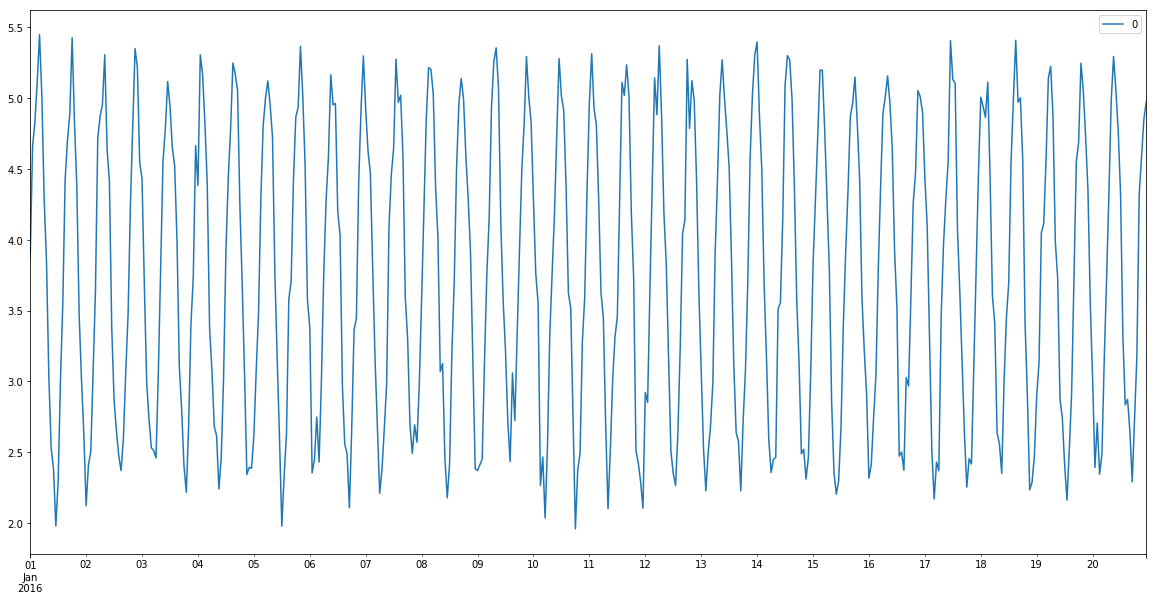

In [5]:
# ------Time series
t0 = '2016-01-01 00:00:00'
freq = 'H'
num_ts = 1

# default - changed in each experiemnt to test different behaviors
noise_level = 0.05
period = 14

# train, test
total_days = 20
tseries_length = total_days * 24 # hourly freq
train_days = 15 * 24

n_steps=2 # we will work with a batch of 2 time steps


time_series_df = generate_synth_tseries(t0, tseries_length, num_ts, period, freq, noise_level)
time_series_df.T.plot()

train_ts = time_series_df.iloc[:, 0:train_days]
ts_X_train, ts_Y_train = split_sequence(train_ts.values[0], n_steps)

test_ts = time_series_df.iloc[:,train_days-1:-1]
ts_X_test, ts_Y_test = split_sequence(test_ts.values[0], n_steps)

## Model

We build a RNN model composed of a single layer of LSTM cells that will model the time serie and several dense (fully connected) layers that will include the quantile.

The model receives:
* A sample [n_timesteps, features] composed of 2 timesteps, start time and end time of the window with 1 feature per timestep, the timestamp.
* The quantile.

In [6]:
def get_model01(timesteps_shape):
    """TODO
    Create a model for the time series
    INPUT:
      IN_timesteps: time series features, dims [timesteps, features]. 
      IN_quantile: quantile to predict, [1].
    OUTPUT:
      DENSE_02: predicted value, [1].
    
    Parameters
    ----------
    timesteps_shape: 2-tuple
        shape of a IN_timesteps sample.    
    
    Returns
    -------
    A keras model.  
    """
    assert(len(timesteps_shape) == 2)
       
    # Inputs
    in_timesteps = tf.keras.Input(
        shape=timesteps_shape,
        name="IN_timesteps"
    )
    in_quantile = tf.keras.Input(
        shape=(1,),
        name="IN_quantile"
    )
    # Flatten features per timestep
    #  It may not be needed if a timestep features is 1
    timesteps_flat = tf.keras.layers.Reshape(
        target_shape = (
            timesteps_shape[0],  # Timesteps
            functools.reduce(operator.mul, timesteps_shape[1:])  # Flatten features
        ),
        name="FLAT_timesteps"
    )(in_timesteps)
    lstm_01 = tf.keras.layers.LSTM(
        units=32,
        activation="relu",
        name="LSTM_01"
    )(timesteps_flat)
    # Add the quantile
    concat_01 = tf.keras.layers.Concatenate(
        name="CONCAT_01"
    )([lstm_01, in_quantile])
    dense_01 = tf.keras.layers.Dense(
        units=16,
        activation=tf.keras.activations.relu,
        name="DENSE_01"
    )(concat_01)
    dense_02 = tf.keras.layers.Dense(
        units=8,
        activation=tf.keras.activations.relu,
        name="DENSE_02"
    )(dense_01)
    dense_03 = tf.keras.layers.Dense(
        units=1,
        activation="linear",
        name="DENSE_03"
    )(dense_01)
    return tf.keras.Model(
        inputs=[in_timesteps, in_quantile],
        outputs=[dense_03],
        name="model01"
    )   

### Loss function

In [7]:
def pinball_loss(y_true, y_pred, quantiles):
    """TODO
    """
    error = (y_true[0] - y_pred[0])
    return tf.reduce_mean( tf.maximum( quantiles*error, (quantiles-1)*error ) )

### Backpropagation

In [8]:
from tensorflow.python.keras.utils.generic_utils import to_list

def train_step(model, optimizer, f_loss, x_train, y_train):
    """Training step for a model.
    """
    with tf.GradientTape() as tape:
        predictions = to_list(model(x_train, training=True))
        loss = f_loss(y_train, predictions, quantiles=x_train[-1])
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

## Train

### Generate batch

TODO: explain [start, end] x n_quantiles

In [9]:
def generate_batch(x_train, y_train, n_quantiles):
    """Cartesian product of training points and Uniform(0,1) sampled quantiles.   
    """
    n_samples = x_train[0].shape[0]
    quantiles = tf.random.uniform(
        name="Quantile_sampler",
        shape=(n_quantiles,),
        minval=1e-2,
        maxval=1.-1e-2
    )
    # Cartesian product
    x_train_batch = [  # Repeat x features
        tf.repeat(
            input=x,
            repeats=quantiles.shape[0],
            axis=0
        ) for x in x_train
    ]
    x_train_batch.append(
        tf.reshape(  # Flatten
            tf.transpose(  # Shape: n_quantiles, n_samples
                tf.reshape(  # Shape:  n_quantiles, n_samples
                    tf.repeat(  # repeat each quantile n_samples
                        input=quantiles,
                        repeats=n_samples,
                        axis=0
                    ),
                    (n_quantiles, n_samples)
                )
            ),
            (-1,)
        )
    )
    y_train_batch = [
        tf.repeat(
            input=y,
            repeats=quantiles.shape[0],
            axis=0
        )
        for y in y_train
    ]
    return (x_train_batch, y_train_batch)

"""
# TEST:
x_train = [np.vstack([np.arange(64)]*2).transpose()]
y_train = [np.arange(64).reshape(64,1)]*2
x,y = generate_batch(x_train, y_train, 5)
"""

'\n# TEST:\nx_train = [np.vstack([np.arange(64)]*2).transpose()]\ny_train = [np.arange(64).reshape(64,1)]*2\nx,y = generate_batch(x_train, y_train, 5)\n'

In [10]:
# Get dataset

x_train = [
    ts_X_train.reshape((  # Each sample is a 2D vector,
        ts_X_train.shape[0],  # Batch size
        ts_X_train.shape[1],  # Timesteps (init, end)
        1                     # Features per timestep (the date)
    )).astype(np.float32)
]

y_train = [
    ts_Y_train.reshape( # The output is a vector per sample
        ts_Y_train.shape[0],  # Batch size
        1
    ).astype(np.float32)
]

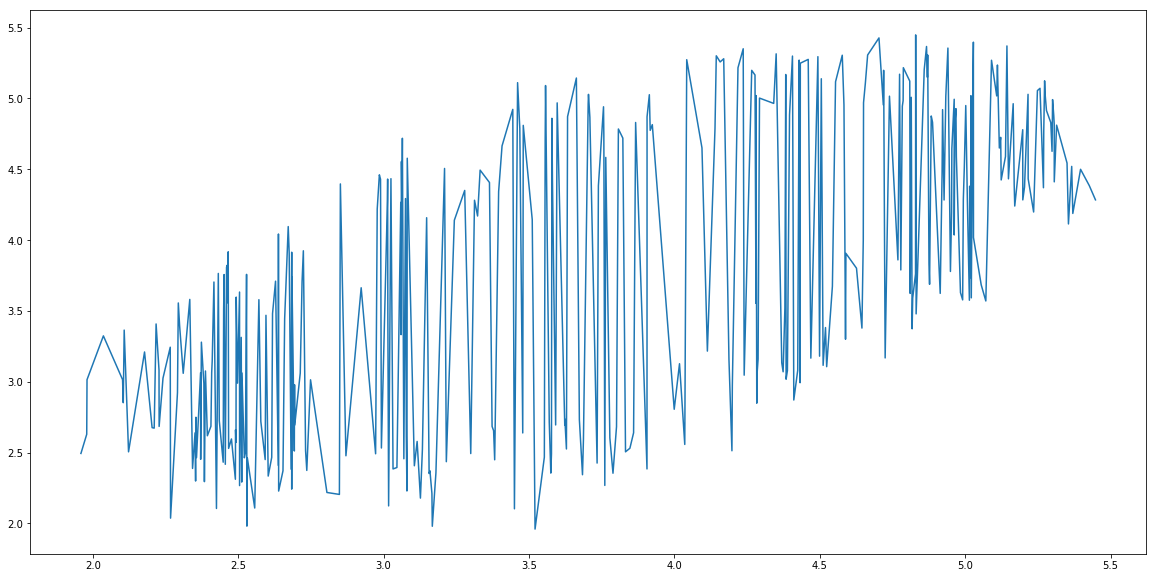

In [11]:
sns.lineplot(x_train[0][:,0,0], y_train[0][:,0])

In [12]:
# Model parameters

f_loss=pinball_loss
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-4,
)
model=get_model01(x_train[0].shape[1:])

model.summary()

Model: "model01"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
IN_timesteps (InputLayer)       [(None, 2, 1)]       0                                            
__________________________________________________________________________________________________
FLAT_timesteps (Reshape)        (None, 2, 1)         0           IN_timesteps[0][0]               
__________________________________________________________________________________________________
LSTM_01 (LSTM)                  (None, 32)           4352        FLAT_timesteps[0][0]             
__________________________________________________________________________________________________
IN_quantile (InputLayer)        [(None, 1)]          0                                            
____________________________________________________________________________________________

In [14]:
# Train


batch_size = 30  # Will multiply with n_quantiles
n_quantiles = 100 # number of quantiles to fit per point
epochs = 200

# Function

len_dataset = len(x_train[0])
indices = tf.range(len_dataset) # All indices for the dataset samples

for epoch in range(epochs):
    tf.random.shuffle(indices)
    i_batch = 0
    while i_batch<len_dataset:
        batch_indices = indices[i_batch:i_batch+batch_size]  # Stochastic batch selection
        x_train_batch, y_train_batch = generate_batch(
            x_train=[
                tf.gather(params=feat_x, indices=batch_indices)
                for feat_x in x_train
            ],
            y_train=[
                tf.gather(params=feat_y, indices=batch_indices)
                for feat_y in y_train
            ],
            n_quantiles=n_quantiles
        )
        loss = train_step(model, optimizer, f_loss, x_train_batch, y_train_batch)
        i_batch += batch_size
    if epoch%10==0:
        print("Epoch: {}\tLoss: {}".format(epoch,loss))

Epoch: 0	Loss: 0.3045577108860016
Epoch: 10	Loss: 0.30261173844337463
Epoch: 20	Loss: 0.29731664061546326
Epoch: 30	Loss: 0.298811137676239
Epoch: 40	Loss: 0.2896898686885834
Epoch: 50	Loss: 0.2893121540546417
Epoch: 60	Loss: 0.28310513496398926
Epoch: 70	Loss: 0.28071150183677673
Epoch: 80	Loss: 0.2788375914096832
Epoch: 90	Loss: 0.27134400606155396


In [16]:
def predict(x, quantile):
    """
    Parameters
    ----------
    x: []
    quantile: float [0,1]
    """
    return to_list(model( 
            x +
            [np.repeat(np.array([[quantile]]), len(x[0]), axis=0)],
        training=False
    ))

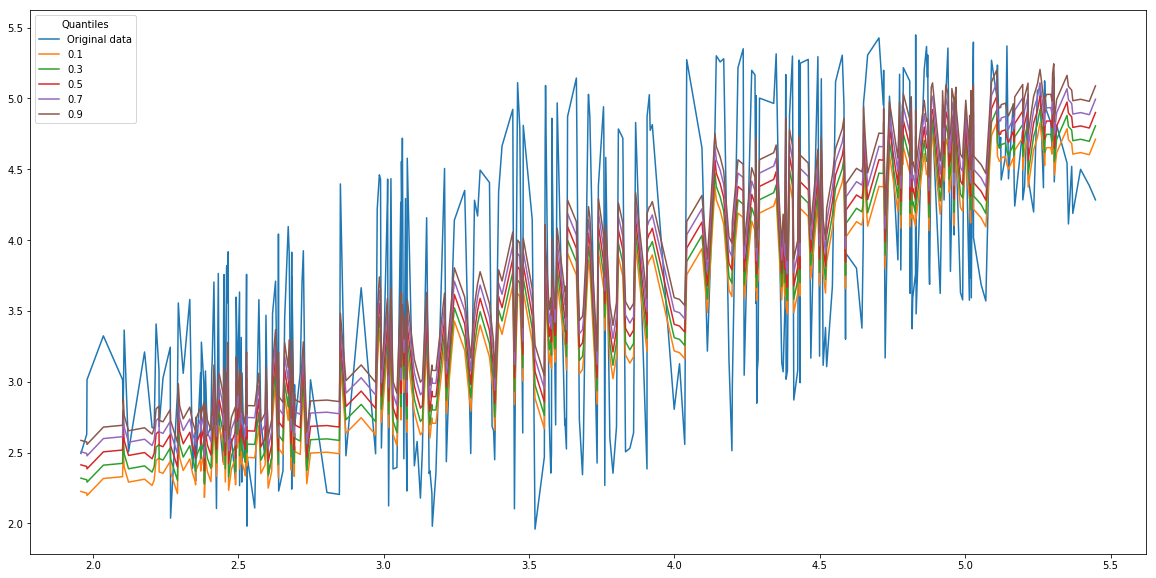

In [17]:
# Plot

quantiles = [.1, .3, .5, .7, 0.9]


sns.lineplot(
    x=x_train[0][:,0,0],
    y=y_train[0][:,0],
    label="Original data"
)


for q in quantiles:
    sns.lineplot(
        x=x_train[0][:,0,0],
        y=predict(x_train, q)[0][:,0],
        label=q
    )

plt.legend(title="Quantiles")

## Test

In [23]:
# Get dataset

x_test = [
    ts_X_test.reshape((  # Each sample is a 2D vector,
        ts_X_test.shape[0],  # Batch size
        ts_X_test.shape[1],  # Timesteps (init, end)
        1                     # Features per timestep (the date)
    )).astype(np.float32)
]

y_test = [
    ts_Y_test.reshape( # The output is a vector per sample
        ts_Y_test.shape[0],  # Batch size
        1
    ).astype(np.float32)
]

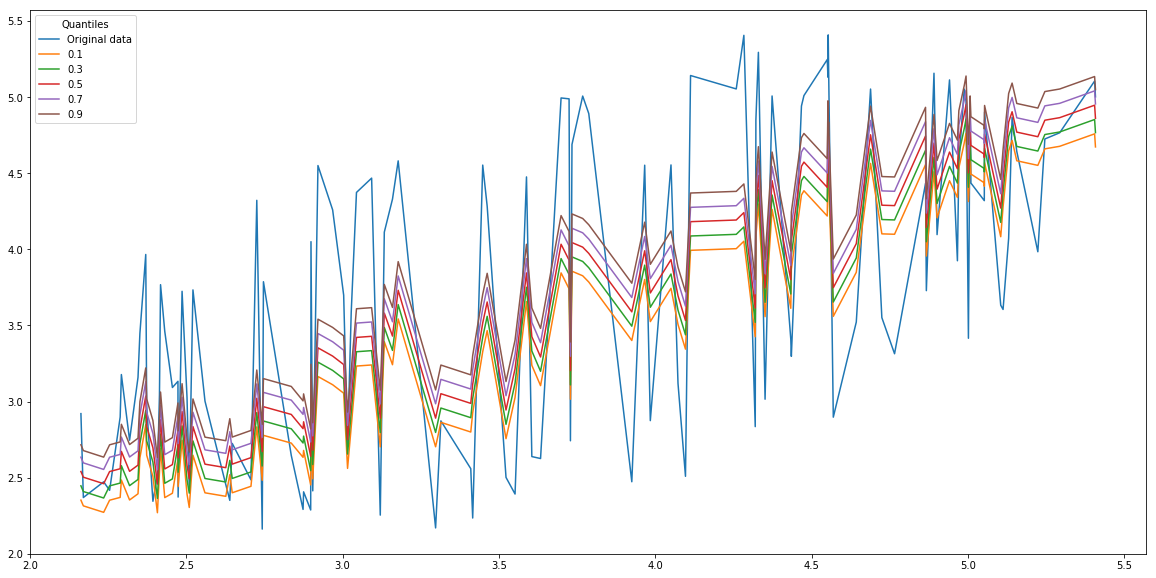

In [24]:
# Plot

quantiles = [.1, .3, .5, .7, 0.9]


sns.lineplot(
    x=x_test[0][:,0,0],
    y=y_test[0][:,0],
    label="Original data"
)


for q in quantiles:
    sns.lineplot(
        x=x_test[0][:,0,0],
        y=predict(x_test, q)[0][:,0],
        label=q
    )

plt.legend(title="Quantiles")

## References

### Quantile Regression
* [Wikipedia - Quantile](https://en.wikipedia.org/wiki/Quantile)
* [Quantile loss function for machine learning](https://www.evergreeninnovations.co/blog-quantile-loss-function-for-machine-learning/)
* [arXiv - Estimating conditional quantiles with the help of the pinball loss](https://arxiv.org/abs/1102.2101)
* [ResearchGate - Kernel Conditional Quantile Estimation via Reduction Revisited](https://www.researchgate.net/publication/220766517_Kernel_Conditional_Quantile_Estimation_via_Reduction_Revisited)

### LSTM
* [TF Doc - Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn)
* [How to Reshape Input Data for Long Short-Term Memory Networks in Keras](https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/)
* [ResearchGate - Probabilistic Individual Load Forecasting Using Pinball Loss Guided LSTM](https://www.researchgate.net/publication/328493229_Probabilistic_Individual_Load_Forecasting_Using_Pinball_Loss_Guided_LSTM)


In [43]:
x_test[0][:,0].min()

2.1627812

In [41]:
x_train[0][:,0].min()

1.9595441